In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as d

import math
import random
import scipy.io
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Global variables
BATCH_SIZE = 512

# Download data

Calls to download datasets. Be careful, you should run those cells only once! It is best to comment them after.

In [3]:
#subprocess.call([
#     "wget", "-P", "./data/",
#     "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
# ])

In [4]:
# subprocess.call([
#     "wget", "-P", "./data/",
#     "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
# ])

# Load data

In [5]:
def load_amat(path):
    mat = scipy.io.loadmat(path)
    x = mat['X']
    y = mat['y']
    x = np.moveaxis(x, 3, 0)
    x = np.moveaxis(x, 3, 1)
    x = x / 255
    return x.astype(np.float32), y

In [6]:
x_train, y_train = load_amat("data/train_32x32.mat")
x_test, _ = load_amat("data/test_32x32.mat")

In [7]:
# we need y_train to be able to stratify the validation split
x_train, x_val = train_test_split(x_train, test_size=0.1, stratify=y_train)

In [8]:
trainloader = DataLoader(x_train, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(x_val, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(x_test, batch_size=BATCH_SIZE, shuffle=False)

# Models

### VAE

In [9]:
class VAE(nn.Module):
    def __init__(self, dim=100):
        super(VAE, self).__init__()

        self.dim = dim

        #ENCODER LAYERS
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32), nn.ELU(), nn.AvgPool2d(
                kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64), nn.ELU(), nn.AvgPool2d(
                kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=6),
            nn.BatchNorm2d(256), nn.ELU())
        self.hidden_1 = nn.Linear(256, 200)

        #DECODER LAYERS
        self.hidden_2 = nn.Linear(100, 256)
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(256), nn.ELU(),
            nn.Conv2d(
                in_channels=256, out_channels=64, kernel_size=6, padding=5),
            nn.BatchNorm2d(64), nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(
                in_channels=64, out_channels=32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32), nn.ELU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(
                in_channels=32, out_channels=16, kernel_size=3, padding=2),
            nn.BatchNorm2d(16), nn.ELU(),
            nn.Conv2d(
                in_channels=16, out_channels=3, kernel_size=3, padding=2),
            nn.BatchNorm2d(3), nn.Sigmoid())

    def encode(self, x):
        q_params = self.hidden_1(self.encoder(x).view(x.shape[0], 256))
        mu = q_params[:, :self.dim]
        logvar = q_params[:, self.dim:]
        return mu, logvar

    def decode(self, z, x):
        # we need x to abstract from the batch size
        return self.decoder(self.hidden_2(z).view(x.shape[0], 256, 1, 1))

    def sample(self, mu, logvar, x):
        # we need x to abstract from the batch size
        eps = torch.randn(x.shape[0], self.dim).to(device)
        return mu + eps * (0.5 * logvar).exp()

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar, x)
        x_hat = self.decode(z, x)
        return x_hat, mu, logvar

    def criterion(self, x_hat, x, mu, logvar):
        # BCE = -log(p) because gradient descent and not ascent
        BCE = F.mse_loss(x_hat, x, reduction="sum")
        KLD = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())
        # criterion returns -ELBO !
        return (BCE + KLD) / x.shape[0]

    def generate(self, sample):
        with torch.no_grad():
            return self.decoder(
                self.hidden_2(sample.to(device)).view(sample.shape[0], 256, 1,
                                                      1))

    def evaluate(self, loader):
        with torch.no_grad():
            loss = 0
            for i, data in enumerate(loader, 1):
                # get the inputs
                x = data.to(device)
                x_hat, mu, logvar = self.forward(x)
                loss += self.criterion(x_hat, x, mu, logvar).item()
        return loss / len(loader)

### GAN

# Train models

### VAE

In [10]:
# create model and move it to device
vae = VAE()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae.to(device)
print("Let's use {}".format(device))

Let's use cuda:0


In [11]:
# this part might fail if you are using a RTX card. Running again this cell should work.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
vae = vae.train()

epoch = 0
early_stopping = 0
best_model = vae
best_val_loss = 9999

while early_stopping < 5:
    epoch += 1
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        x = data.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae.forward(x)
        loss = vae.criterion(x_hat, x, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / i
    val_loss = vae.evaluate(validloader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = vae
        early_stopping = 0
        print(
            'epoch {:2d}:  loss: {:6.2f}  val_loss: {:6.2f} [NEW BEST]'.format(
                epoch, train_loss, val_loss))
    else:
        early_stopping += 1
        print('epoch {:2d}:  loss: {:6.2f}  val_loss: {:6.2f}'.format(
            epoch, train_loss, val_loss))
vae = best_model
vae = vae.eval()

/home/quentin/venv/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch  1:  loss:  85.15  val_loss:  73.38 [NEW BEST]
epoch  2:  loss:  71.39  val_loss:  68.71 [NEW BEST]
epoch  3:  loss:  67.72  val_loss:  65.74 [NEW BEST]
epoch  4:  loss:  64.73  val_loss:  62.68 [NEW BEST]
epoch  5:  loss:  61.25  val_loss:  59.11 [NEW BEST]
epoch  6:  loss:  57.86  val_loss:  56.02 [NEW BEST]
epoch  7:  loss:  55.19  val_loss:  53.65 [NEW BEST]
epoch  8:  loss:  53.01  val_loss:  51.94 [NEW BEST]
epoch  9:  loss:  51.33  val_loss:  50.29 [NEW BEST]
epoch 10:  loss:  49.97  val_loss:  49.14 [NEW BEST]
epoch 11:  loss:  48.83  val_loss:  48.23 [NEW BEST]
epoch 12:  loss:  47.86  val_loss:  47.27 [NEW BEST]
epoch 13:  loss:  46.96  val_loss:  46.37 [NEW BEST]
epoch 14:  loss:  46.08  val_loss:  45.54 [NEW BEST]
epoch 15:  loss:  45.33  val_loss:  44.91 [NEW BEST]
epoch 16:  loss:  44.64  val_loss:  44.36 [NEW BEST]
epoch 17:  loss:  44.03  val_loss:  43.63 [NEW BEST]
epoch 18:  loss:  43.41  val_loss:  43.12 [NEW BEST]
epoch 19:  loss:  42.92  val_loss:  42.57 [NEW

### GAN

# Generate sample

In [12]:
def generate_samples(model, size=9):
    with torch.no_grad():
        images = model.generate(torch.randn(size, 100)).cpu().numpy()
        images = np.moveaxis(images, 1, 3)
        grid = math.floor(math.sqrt(len(images)))
        f, axis = plt.subplots(grid, grid, figsize=(6, 6))
        for i in range(grid):
            for j in range(grid):
                axis[i, j].imshow(images[i * grid + j])
                axis[i, j].set_axis_off()
                axis[i, j].set_aspect('equal')
        f.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

### VAE

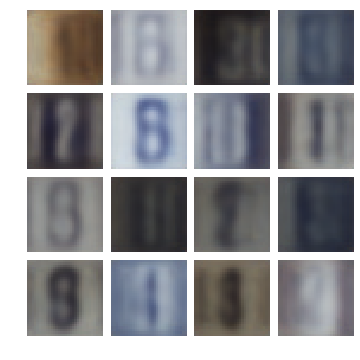

In [13]:
generate_samples(vae, size=16)

### GAN

In [14]:
# generate_samples(gan, size=16)

# Disentangled representation 

In [15]:
def disentangle(model, dim=[0, 1, 2], eps=0.01, size=10):
    with torch.no_grad():
        z = torch.randn(1, 100)
        f, axis = plt.subplots(len(dim), size, figsize=(size, len(dim)))
        for i, d in enumerate(dim):
            interpolation = z.repeat(size, 1)
            for j, s in enumerate(interpolation):
                interpolation[j][d] += (j - size / 2) * eps
            images = model.generate(interpolation).cpu().numpy()
            images = np.moveaxis(images, 1, 3)
            for j, img in enumerate(images):
                if j == 0:
                    axis[i, j].set_ylabel(
                        'dim {}'.format(d), labelpad=20, rotation='horizontal')
                axis[i, j].imshow(img)
                axis[i, j].get_xaxis().set_ticks([])
                axis[i, j].get_yaxis().set_ticks([])
                axis[i, j].set_aspect('equal')
        f.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

### VAE

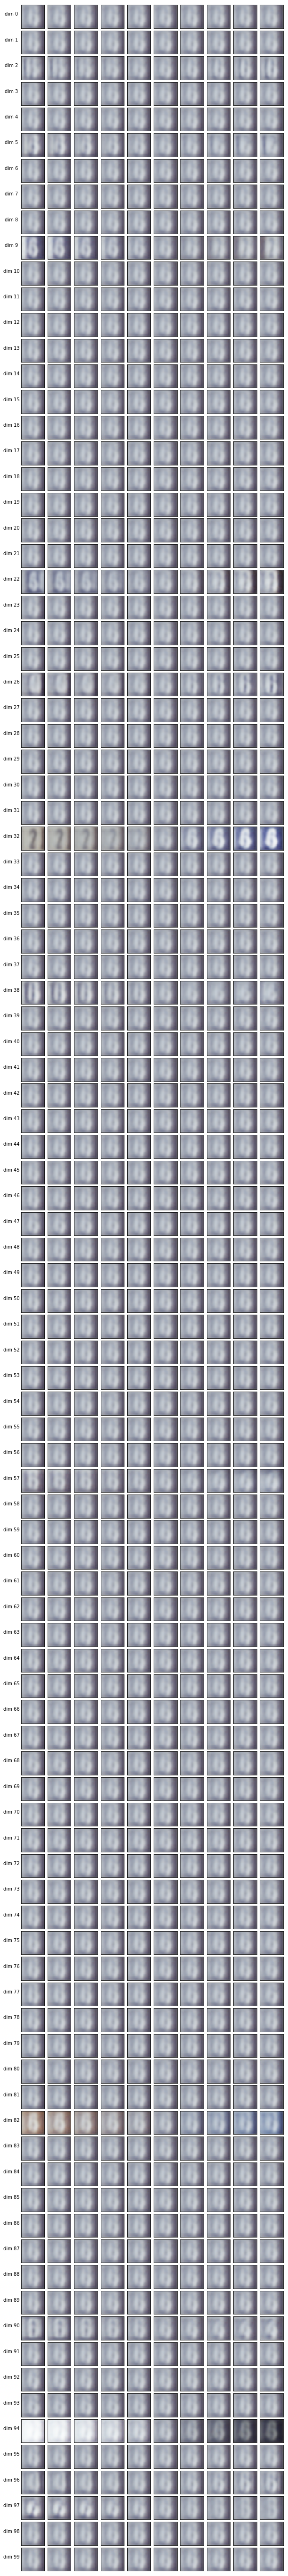

In [26]:
disentangle(vae, dim=range(100), eps=0.5, size=10)

### GAN

In [17]:
# disentangle(gan, dim=range(100), eps=0.1, size=10)

# Interpolate between two points

## In latent space

In [18]:
def latent_interpolation(model, size):
    with torch.no_grad():
        z1 = torch.randn(1, 100)
        z2 = torch.randn(1, 100)
        eps = (z2 - z1) / size
        z = z1.repeat(size, 1)
        for i, s in enumerate(z):
            z[i] = s + i * eps
        images = model.generate(z).cpu().numpy()
        images = np.moveaxis(images, 1, 3)
        f, axis = plt.subplots(1, size, figsize=(size, 3))
        for i, img in enumerate(images):
            axis[i].imshow(img)
            axis[i].set_axis_off()
            axis[i].set_aspect('equal')
        f.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

### VAE

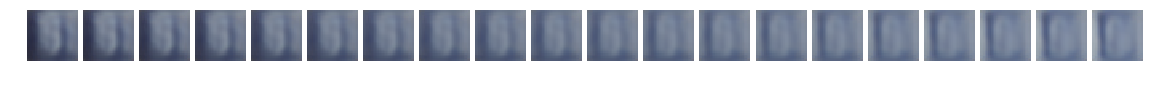

In [35]:
latent_interpolation(vae, 20)

### GAN

In [20]:
# latent_interpolation(gan, 10)

## In original space

In [67]:
def original_interpolation(model, size):
    with torch.no_grad():
        x1, x2 = random.sample(list(x_test), 2)
        x1 = x1.reshape(1, 3, 32, 32)
        x2 = x2.reshape(1, 3, 32, 32)
        eps = (x2 - x1) / size
        x = x1.repeat(size, 0)
        for i, s in enumerate(x):
            x[i] = s + i * eps
        x = torch.from_numpy(x).to(device)
        images = model.forward(x)[0].cpu().numpy()
        images = np.moveaxis(images, 1, 3)
        f, axis = plt.subplots(1, size, figsize=(size, 3))
        for i, img in enumerate(images):
            axis[i].imshow(img)
            axis[i].set_axis_off()
            axis[i].set_aspect('equal')
        f.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

### VAE

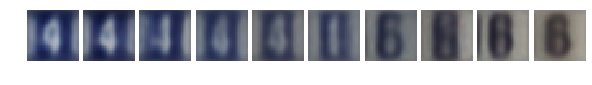

In [68]:
original_interpolation(vae, 10)

### GAN

In [23]:
# original_interpolation(gan, 10)